In [23]:
# dataframe
import pandas as pd
import numpy as np

# logistic regression
from sklearn.linear_model import LogisticRegression

# XGBoost
import xgboost as xgb

# train/test split
from sklearn.model_selection import train_test_split

# confusion matrix
import matplotlib.pyplot as plt
from sklearn import metrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# config file
pd.set_option('display.max_columns', 100)
from pyaml_env import parse_config
config = parse_config('config.yaml')


In [24]:
# load dataset, filter to feature columns
df = pd.read_pickle('data/generated_games.pkl')
feature_col = [str(x) + '_team' for x in config['scoring_ranges'].keys()]
target_col = config['target_variable']

In [35]:
df.head(1)

,game_id,a1_team,a1_goals,a2_team,a2_goals,a3_team,a3_goals,b1_team,b1_goals,b2_team,b2_goals,b3_team,b3_goals,c1_team,c1_goals,c2_team,c2_goals,d1_team,d1_goals,d2_team,d2_goals,score_difference,team1_victory
0,1,1,1,0,2,0,2,1,1,1,0,1,1,1,-1,0,0,0,-2,0,-2,2,1


In [25]:
# split dataframe into target and feature columns
df_base = df[feature_col]
df_target = df[target_col]

In [26]:
# train/test split with set state
x_train, x_test, y_train, y_test = train_test_split(df_base, df_target, test_size=0.25, random_state=0)

## Logistic Regression

In [27]:
# default logistic regression
model = LogisticRegression()
# training
model.fit(x_train, y_train)

LogisticRegression()

In [28]:
# predict on test
y_pred = model.predict(x_test)
# confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[12  0]
 [ 2 11]]


Text(0.5, 427.9555555555555, 'Predicted label')

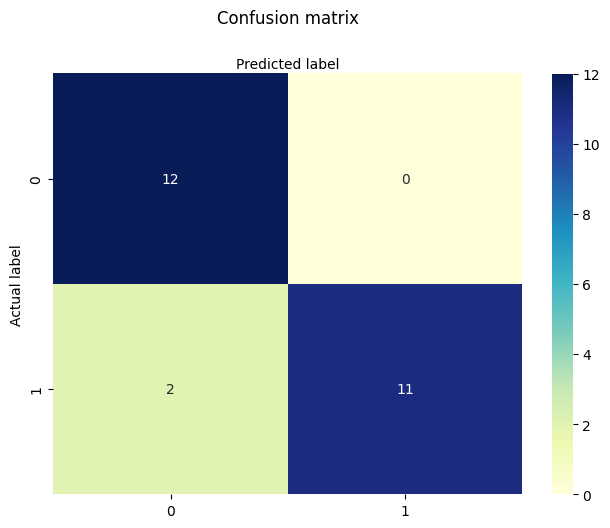

In [29]:
# Better looking confusion matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

The basic logistic regression model predicts this dataset pretty well!

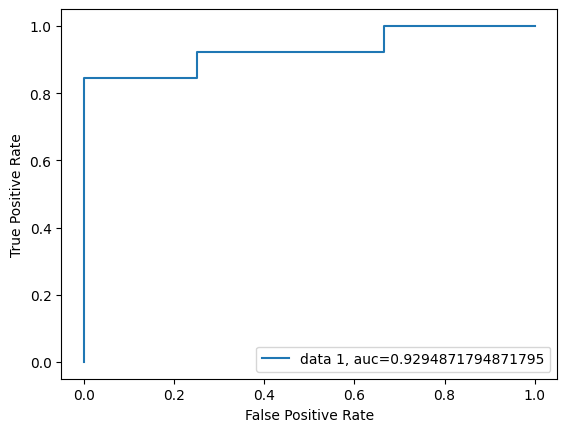

In [30]:
# ROC curve
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

ROC curve shows good trade off between true and false positive rates as we vary the threshold for determination. The model performs admirably

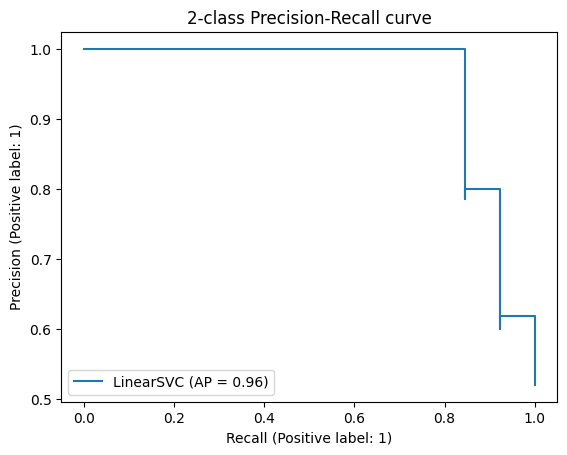

In [62]:
display = metrics.PrecisionRecallDisplay.from_estimator(
    model, x_test, y_test, name="LinearSVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

Here we see the trade off between precision and recall across possible thresholds

In [63]:
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

Precision: 1.000000
Recall: 0.846154
F1 score: 0.916667


In [64]:
feat_importance = pd.DataFrame(data={
    'Player': x_train.columns,
    'Weight': model.coef_[0]
})
feat_importance = feat_importance.sort_values(by='Weight', ascending=False)

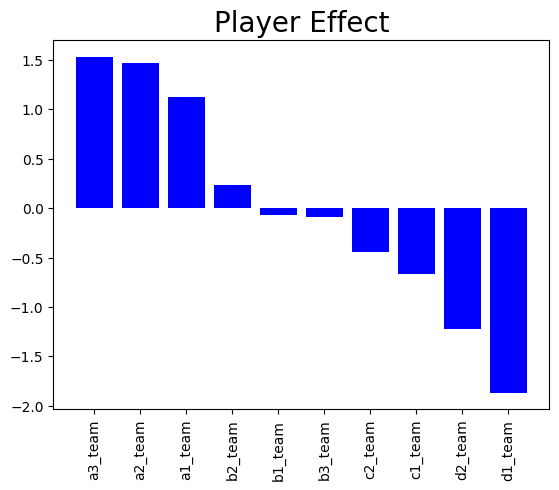

In [66]:
plt.bar(x=feat_importance['Player'], height=feat_importance['Weight'], color='blue')
plt.title('Player Effect', size=20)
plt.xticks(rotation='vertical')
plt.xlabel("Team Presence")
plt.ylabel("Relative Importance")
plt.show()

As Anticipated, the 'A' players have the highest impact on team 1 victory predictability when on team 1, whereas 'D' players are negatively impacting target variable. Interestingly, the 'B' players, who each range from [0,1] goal delta per game, have minimal model predictive capabilities despite being on average an asset to their team

## XGBoost

Now lets take the same dataset and see how an XGBoost model performs

In [31]:
model_xgb = xgb.XGBClassifier()

In [32]:
model_xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [33]:
feat_importance_xgb = pd.DataFrame(data={
    'Player': x_train.columns,
    'Weight': model_xgb.feature_importances_
})
feat_importance_xgb = feat_importance_xgb.sort_values(by='Weight', ascending=False)

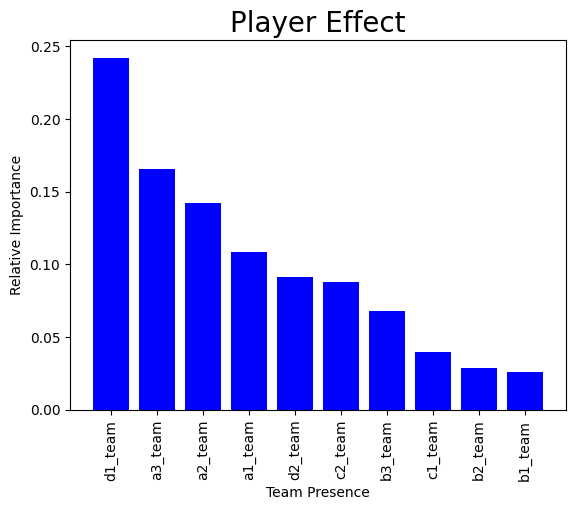

In [34]:
plt.bar(x=feat_importance_xgb['Player'], height=feat_importance_xgb['Weight'], color='blue')
plt.title('Player Effect', size=20)
plt.xticks(rotation='vertical')
plt.xlabel("Team Presence")
plt.ylabel("Relative Importance")
plt.show()

XGBoost does not have the same feature importance coorelation as linear regression models have, but the results are analogous: 'D' and 'A' players have the biggest impact on the target variable. Note the model does not use all the possible variables as a result of the max depth default setting acting as a limiter

In [35]:
# predict on test
y_pred = model_xgb.predict(x_test)

# confusion matrix
cm_xgb = metrics.confusion_matrix(y_test, y_pred)
print(cm_xgb)

[[9 3]
 [4 9]]


Text(0.5, 427.9555555555555, 'Predicted label')

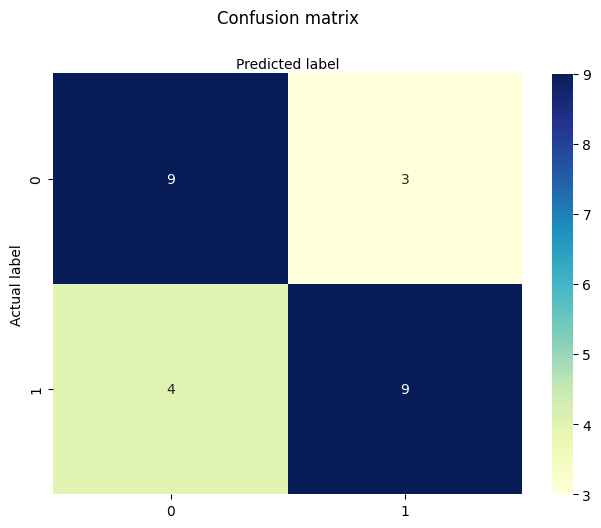

In [36]:
# Better looking confusion matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm_xgb), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Our XGBoost model is less often correct than the logistic regression model on our validation set

In [37]:
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

Precision: 0.750000
Recall: 0.692308
F1 score: 0.720000


Precision and recall all lower than logistic regression.

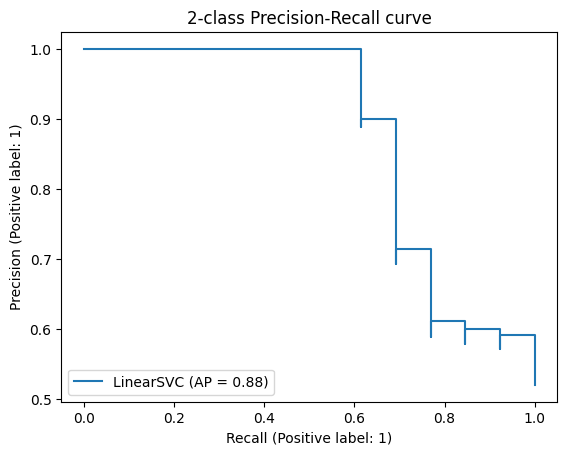

In [38]:
display = metrics.PrecisionRecallDisplay.from_estimator(
    model_xgb, x_test, y_test, name="LinearSVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

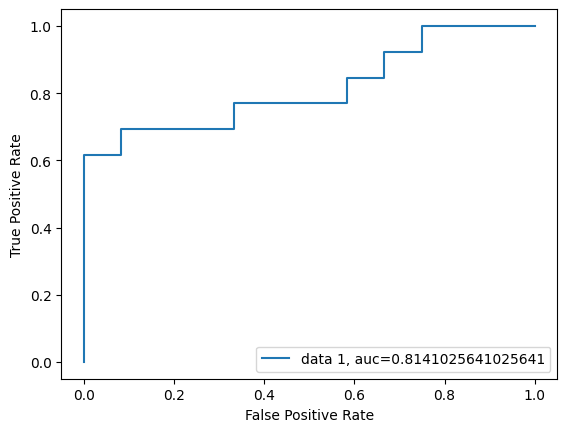

In [39]:
# ROC curve
y_pred_proba = model_xgb.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

Much worse ROC curve and a much more noticible trade-off in true positive and false positive rates, as well as recall/precision

## Conclusions and Next Steps

### Conclusion
So, is Logistic regression better? Well, maybe...

We have some evidence to move forward with a logistic regression model for this type of problem but there are still more experiments to perform. Adjustment of the threshold on the classifier could prove fruitful in both deciding between the offered models as well as tuning the choosen model for the metric we care about most, whether it be precision or recall or a combination of them represented by a third metric such as the F1 score. How these models perform on new data is of minimal concern as our random processes should have mapped much of the team possibilities, but for future endeavours we have to be a bit more careful for overfitting and how well the data extrapolates to the yet unseen population of possibilities.

### Next Steps
Next steps would be to optimize hyperparameters for the metric we most care about for our model. Additionally, an expansion of the player base and team size to better match the reality of the problem: teams often consist of more than 5 players and not everyone is in attendance each week.

How will Logistic Regression perform relative to XGBoost on a less straightforward dataset?